**TODO :**
- Recheck Augmentations
- Recheck LAB normalization
- sampler for faster convergence ?

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [2]:
import os
import sys
import torch
import zipfile
import numpy as np
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("../code/")

In [3]:
from params import *

from data.transforms import HE_preprocess
from data.dataset import TileDataset

from model_zoo.models import define_model

from training.main import k_fold
from utils.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    update_overall_logs,
)

from utils.plots import plot_contours

from params import *

### Load

In [4]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")
df = pd.read_csv(OUT_PATH + f"df_images_{TILE_SIZE}_{REDUCE_FACTOR}.csv")

## Model

In [7]:
def get_tile_weighting(size, sigma=1, alpha=1, eps=1e-6):
    half = size // 2
    w = np.ones((size, size), np.float32)

    x = np.concatenate([np.mgrid[-half:0], np.mgrid[1: half + 1]])[:, None]
    x = np.tile(x, (1, size))
    x = half + 1 - np.abs(x)
    y = x.T

    w = np.minimum(x, y)
    w = (w / w.max()) ** sigma
    w = np.minimum(w, 1)

    w = (w - np.min(w) + eps) / (np.max(w) - np.min(w) + eps)

    w = np.where(w > alpha, 1, w)
    w = w / alpha
    w = np.clip(w, 1e-3, 1)

    w = np.round(w, 3)
    return w.astype(np.float16)

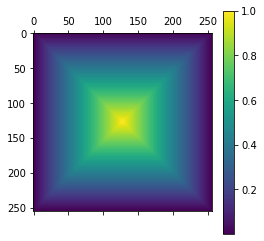

In [8]:
w = get_tile_weighting(256)

plt.matshow(w.astype(float))
plt.colorbar()

In [9]:
from training.lovasz import *

In [10]:
dataset = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=False),
)

In [11]:
model = define_model("Unet", "resnet18")

In [12]:
img, y = dataset[0]

In [13]:
pred = model(img.unsqueeze(0))

In [14]:
symmetric_lovasz(pred, y.unsqueeze(0))

tensor([10.0055], grad_fn=<DivBackward0>)

## Training

In [15]:
BATCH_SIZES = {
    "resnet18": 64,
    "resnet34": 32, 
    "resnext50_32x4d": 32, 
    "se_resnext50_32x4d": 32,
    "efficientnet-b1": 16,
    "efficientnet-b2": 16,
    "efficientnet-b3": 16,
    "efficientnet-b4": 16,
    "efficientnet-b5": 16,
    "efficientnet-b6": 8,
}

In [16]:
class Config:
    """
    Parameters used for training
    """
    
    # General
    seed = 42
    verbose = 1
    img_dir = IMG_PATH
    mask_dir = MASK_PATH
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True
    iter_per_epoch = 5000 #10000
    
    # Image size
    train_tile_size = 256
    reduce_factor = 4
    on_spot_sampling = 0.9

    # k-fold
    cv_column = "5fold"
    random_state = 0
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    encoder = "efficientnet-b5"  # "resnet18" "resnext50_32x4d", "resnet34", "efficientnet-b5"
    decoder = "Unet"  # "Unet", "DeepLabV3Plus"
    encoder_weights = "imagenet"
    num_classes = 1

    # Training
    loss = "BCEWithLogitsLoss"  # "SoftDiceLoss" / "BCEWithLogitsLoss"  / "lovasz"
    activation = "none" if loss == "lovasz" else "sigmoid"

    optimizer = "Adam"
    batch_size = BATCH_SIZES[encoder]
    
         
    if batch_size == 32:
        epochs = 40
    elif batch_size >= 6:
        epochs = 30
    elif batch_size == 8:
        epochs = 20
        
    if train_tile_size == 512:
        batch_size = int(batch_size/4)

    lr = 1e-3
    swa_first_epoch = 50

    warmup_prop = 0.05
    val_bs = batch_size * 2

    first_epoch_eval = 0

    # Inference
    overlap_factor = 2


In [17]:
DEBUG = True
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    df.to_csv(log_folder + "data.csv", index=False)
    create_logger(directory=log_folder, name="logs.txt")

metrics = k_fold(Config, df, log_folder=log_folder)

Logging results to ../logs/2021-04-01/1/

-------------   Fold 1 / 5  -------------

    -> 8371 training images
    -> 1831 validation images
    -> 20225689 trainable parameters

Epoch 01/40 	 lr=5.0e-04	 t=143s	loss=0.198	val_loss=0.031 	 dice=0.8795
Epoch 02/40 	 lr=1.0e-03	 t=143s	loss=0.026	val_loss=0.077 	 dice=0.6752
Epoch 03/40 	 lr=9.7e-04	 t=143s	loss=0.018	val_loss=0.015 	 dice=0.9009
Epoch 04/40 	 lr=9.5e-04	 t=143s	loss=0.014	val_loss=0.013 	 dice=0.9138
Epoch 05/40 	 lr=9.2e-04	 t=143s	loss=0.014	val_loss=0.023 	 dice=0.8568
Epoch 06/40 	 lr=8.9e-04	 t=143s	loss=0.013	val_loss=0.016 	 dice=0.8756
Epoch 07/40 	 lr=8.7e-04	 t=144s	loss=0.012	val_loss=0.014 	 dice=0.8831
Epoch 08/40 	 lr=8.4e-04	 t=143s	loss=0.012	val_loss=0.022 	 dice=0.8720
Epoch 09/40 	 lr=8.2e-04	 t=143s	loss=0.012	val_loss=0.013 	 dice=0.9180
Epoch 10/40 	 lr=7.9e-04	 t=144s	loss=0.015	val_loss=0.014 	 dice=0.9136
Epoch 11/40 	 lr=7.6e-04	 t=143s	loss=0.012	val_loss=0.012 	 dice=0.9120
Epoch 12/40 	 lr